In [1]:
# ✅ 1. Nâng pip
%pip install -q -U pip

# ✅ 2. Cài toàn bộ stack Hugging Face + eval + Arrow
%pip install -q \
  "transformers>=4.44,<5.0.0" \
  "accelerate" \
  "sentencepiece" \
  "evaluate>=0.4.2" \
  "rouge-score" \
  "pyarrow>=21.0.0" \
  "datasets>=4.1.0" \
  "huggingface_hub>=0.34.0,<1.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is i

# 1. Library

In [4]:
# datasets
from datasets import (
    load_dataset,
    Dataset,
    DatasetDict,
    load_from_disk,
)

# transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    TrainerCallback,
)
from transformers.trainer_utils import get_last_checkpoint

# libs khác
import numpy as np
import evaluate
import json
import shutil
import pandas as pd
import torch

# để kiểm tra version & làm việc với Arrow
import datasets
import pyarrow
import transformers


In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"

# 2. Load dataset

In [16]:
# raw_dataset = load_dataset("nam194/vietnews")

## Downsample dataset

In [17]:
# def downsample(ds, target_size, seed=42):
#     """Shuffle rồi lấy target_size mẫu đầu tiên."""
#     ds = ds.shuffle(seed=seed)
#     n_keep = min(len(ds), target_size)
#     return ds.select(range(n_keep))

In [18]:
# TARGET_TRAIN = 10_000
# TARGET_VAL   = 2_000
# TARGET_TEST  = 2_000
# SEED = 42


# small_dataset = DatasetDict({
#     "train":      downsample(raw_dataset["train"],      TARGET_TRAIN, SEED),
#     "validation": downsample(raw_dataset["validation"], TARGET_VAL,   SEED),
#     "test":       downsample(raw_dataset["test"],       TARGET_TEST,  SEED),
# })


# print("train:", len(small_dataset["train"]))
# print("val:",   len(small_dataset["validation"]))
# print("test:",  len(small_dataset["test"]))

In [19]:
# save_path = '/content/drive/MyDrive/NLP/vietnamese_sumarization/vietnews_dataset_small'

# small_dataset.save_to_disk(save_path)
# print("Đã lưu dataset nhỏ vào:", save_path)

## Load small dataset

In [20]:
small_dataset = load_from_disk('/kaggle/input/vietnews/vietnews_dataset_small')

train_dataset = small_dataset["train"]
val_dataset  = small_dataset["validation"]
test_dataset  = small_dataset["test"]

## View train

In [21]:
train_dataset.to_pandas().head()

,guid,title,abstract,article
0,18107,Dự_án BT : Mảnh đất màu_mỡ cho tham_nhũng,"Hàng_loạt những bất_cập , hạn_chế trong hình_t...",Hầu_hết dự_án BT đầu_tư bằng hình_thức chỉ_địn...
1,9817,"' Thành_phố thông_minh ' : Tăng tiện_ích , khô...",Đề_án xây_dựng TP. HCM trở_thành đô_thị thông_...,"Trao_đổi với Tuổi_Trẻ , ông TRẦN VĨNH_TUYẾN - ..."
2,9624,Đại_diện chương_trình Sau ánh hào_quang nói gì...,"Trong chương_trình Sau ánh hoà_quang , Lê_Gian...","Mới_đây , diễn_viên Duy_Phương vướng lùm xùm k..."
3,3742,"Bị bắt quả_tang đang vận_chuyển heroin , 2 đối...","2 anh_em ruột mua ma_tuý ở biên_giới , trên đư...","Báo Vietnamplus đăng_tải , vào lúc 13 giờ ngày..."
4,57875,Tiêm_kích Mỹ bắn hạ UAV của phe thân chính_phủ...,Một máy_bay_không_người_lái của lực_lượng ủng_...,Tiêm_kích F -15 của Mỹ diễn_tập phóng tên_lửa ...


In [22]:
train_dataset.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guid      10000 non-null  int64 
 1   title     10000 non-null  object
 2   abstract  10000 non-null  object
 3   article   10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


## View val

In [23]:
val_dataset.to_pandas().head()

,guid,title,abstract,article
0,20620,"Đại_biểu Phong_Lan : ' Cử_tri đến khóc , chúng...",""" Vai_trò của mình chỉ như người chuyển thư , ...","Sáng 23/3 , thảo_luận về báo_cáo tổng_kết nhiệ..."
1,9003,Cựu công_tố_viên Hàn đi tù vì sàm_sỡ đồng_nghiệp,"Toà kết_án cựu công_tố_viên hai năm tù , sau k...",Ahn_Tae - geun tại Seoul ngày 23/1 . Ahn_Tae -...
2,14767,Chân_dung nữ Chủ_tịch Uỷ_ban Mặt_trận Tổ_quốc ...,Tân Chủ_tịch Uỷ_ban Mặt_trận Tổ_quốc ( MTTQ ) ...,"Ngày 14/3 , Uỷ_ban MTTQ Việt_Nam thành_phố Hà_..."
3,6314,Sau những tuyên_bố của Mỹ - Triều : Chảo lửa B...,Trong một tuyên_bố tại Hội_nghị an_ninh khu_vự...,"Triều_Tiên cứng_rắn giữa "" muôn_trùng vây "" "" ..."
4,5599,Chờ giây_phút ... Việt_Nam trúng_cử Hội_đồng B...,"Dự_kiến tối 7-6 ( giờ Việt_Nam ) , Đại_hội_đồn...",Với tư_cách đại_diện duy_nhất cho nhóm các nướ...


In [24]:
val_dataset.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guid      2000 non-null   int64 
 1   title     2000 non-null   object
 2   abstract  2000 non-null   object
 3   article   2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


## View test

In [25]:
test_dataset.to_pandas().head()

,guid,title,abstract,article
0,5235,Ấn_Độ tính học kinh_nghiệm Việt_Nam trong thu_...,Nguồn_tin của hãng Bloomberg cho_biết cơ_quan_...,"Theo Hãng tin Bloomberg , trong bối_cảnh nhiều..."
1,20570,30 hành_khách kêu cứu trong xe giường nằm lật ...,"Sau cú tông với xe_tải ở Bình_Dương , ôtô khác...","Hiện_trường vụ tai_nạn . Sáng 6/3 , ông Phạm_N..."
2,18797,Truyền_hình - kẻ hạ_sát văn_chương,Don Delillo viết : ' Đối_với hầu_hết mọi người...,"Ra_mắt vào năm 1985 , tiểu_thuyết Tạp_âm trắng..."
3,8831,"Nghi gặp sự_cố , phi_công F -16 Mỹ bỏ hai thùn...",Tiêm_kích F -16 Mỹ huấn_luyện ở phía tây nam H...,Tiêm_kích F -16 Mỹ tại Hàn_Quốc với hai thùng ...
4,22607,Hà_Nội di_dời Sở Kế_hoạch và Đầu_tư để mở_rộng...,Sân_vận_động Hàng_Đẫy sẽ được mở_rộng diện_tíc...,UBND TP Hà_Nội vừa ban_hành thông_báo kết_luận...


In [26]:
test_dataset.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guid      2000 non-null   int64 
 1   title     2000 non-null   object
 2   abstract  2000 non-null   object
 3   article   2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


## Clean train, val, test

In [27]:
def clean_text(text: str) -> str:
  # xoá xuống dòng thừa, thay _ bằng khoảng trắng…
  text = text.replace("\n", " ").replace("\r", " ")
  text = text.replace("_", " ")

  return " ".join(text.split())

In [28]:
def preprocess_batch(batch):
  batch['article'] = [clean_text(t) for t in batch['article']]
  batch['abstract'] = [clean_text(t) for t in batch['abstract']]

  return batch

In [29]:
train_ds_clean = train_dataset.map(
    preprocess_batch,
    batched=True,
    cache_file_name="/kaggle/working/train_clean.arrow",
    load_from_cache_file=False,   # lần đầu
)

val_ds_clean = val_dataset.map(
    preprocess_batch,
    batched=True,
    cache_file_name="/kaggle/working/val_clean.arrow",
    load_from_cache_file=False,
)

test_ds_clean = test_dataset.map(
    preprocess_batch,
    batched=True,
    cache_file_name="/kaggle/working/test_clean.arrow",
    load_from_cache_file=False,
)


Map: 100%|##########| 10000/10000 [00:00<?, ? examples/s]

Map: 100%|##########| 2000/2000 [00:00<?, ? examples/s]

Map: 100%|##########| 2000/2000 [00:00<?, ? examples/s]

In [30]:
train_ds_clean.to_pandas().head()

,guid,title,abstract,article
0,18107,Dự_án BT : Mảnh đất màu_mỡ cho tham_nhũng,"Hàng loạt những bất cập , hạn chế trong hình t...",Hầu hết dự án BT đầu tư bằng hình thức chỉ địn...
1,9817,"' Thành_phố thông_minh ' : Tăng tiện_ích , khô...",Đề án xây dựng TP. HCM trở thành đô thị thông ...,"Trao đổi với Tuổi Trẻ , ông TRẦN VĨNH TUYẾN - ..."
2,9624,Đại_diện chương_trình Sau ánh hào_quang nói gì...,"Trong chương trình Sau ánh hoà quang , Lê Gian...","Mới đây , diễn viên Duy Phương vướng lùm xùm k..."
3,3742,"Bị bắt quả_tang đang vận_chuyển heroin , 2 đối...","2 anh em ruột mua ma tuý ở biên giới , trên đư...","Báo Vietnamplus đăng tải , vào lúc 13 giờ ngày..."
4,57875,Tiêm_kích Mỹ bắn hạ UAV của phe thân chính_phủ...,Một máy bay không người lái của lực lượng ủng ...,Tiêm kích F -15 của Mỹ diễn tập phóng tên lửa ...


In [31]:
val_ds_clean.to_pandas().head()

,guid,title,abstract,article
0,20620,"Đại_biểu Phong_Lan : ' Cử_tri đến khóc , chúng...",""" Vai trò của mình chỉ như người chuyển thư , ...","Sáng 23/3 , thảo luận về báo cáo tổng kết nhiệ..."
1,9003,Cựu công_tố_viên Hàn đi tù vì sàm_sỡ đồng_nghiệp,"Toà kết án cựu công tố viên hai năm tù , sau k...",Ahn Tae - geun tại Seoul ngày 23/1 . Ahn Tae -...
2,14767,Chân_dung nữ Chủ_tịch Uỷ_ban Mặt_trận Tổ_quốc ...,Tân Chủ tịch Uỷ ban Mặt trận Tổ quốc ( MTTQ ) ...,"Ngày 14/3 , Uỷ ban MTTQ Việt Nam thành phố Hà ..."
3,6314,Sau những tuyên_bố của Mỹ - Triều : Chảo lửa B...,Trong một tuyên bố tại Hội nghị an ninh khu vự...,"Triều Tiên cứng rắn giữa "" muôn trùng vây "" "" ..."
4,5599,Chờ giây_phút ... Việt_Nam trúng_cử Hội_đồng B...,"Dự kiến tối 7-6 ( giờ Việt Nam ) , Đại hội đồn...",Với tư cách đại diện duy nhất cho nhóm các nướ...


In [32]:
test_ds_clean.to_pandas().head()

,guid,title,abstract,article
0,5235,Ấn_Độ tính học kinh_nghiệm Việt_Nam trong thu_...,Nguồn tin của hãng Bloomberg cho biết cơ quan ...,"Theo Hãng tin Bloomberg , trong bối cảnh nhiều..."
1,20570,30 hành_khách kêu cứu trong xe giường nằm lật ...,"Sau cú tông với xe tải ở Bình Dương , ôtô khác...","Hiện trường vụ tai nạn . Sáng 6/3 , ông Phạm N..."
2,18797,Truyền_hình - kẻ hạ_sát văn_chương,Don Delillo viết : ' Đối với hầu hết mọi người...,"Ra mắt vào năm 1985 , tiểu thuyết Tạp âm trắng..."
3,8831,"Nghi gặp sự_cố , phi_công F -16 Mỹ bỏ hai thùn...",Tiêm kích F -16 Mỹ huấn luyện ở phía tây nam H...,Tiêm kích F -16 Mỹ tại Hàn Quốc với hai thùng ...
4,22607,Hà_Nội di_dời Sở Kế_hoạch và Đầu_tư để mở_rộng...,Sân vận động Hàng Đẫy sẽ được mở rộng diện tíc...,UBND TP Hà Nội vừa ban hành thông báo kết luận...


# 3. Load model

In [33]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

# 4. Tokenize input (artical) & target (abstract)

In [34]:
# Đo độ dài token cho article

def measure_article_len(batch):
  tokens = tokenizer(
      batch['article'],
      truncation=False,
      add_special_tokens=True
  )
  lengths = [len(ids) for ids in tokens['input_ids']]
  return {"article_len": lengths}


train_with_len = train_ds_clean.map(
    measure_article_len,
    batched=True,
    batch_size=256
)

lens = np.array(train_with_len["article_len"])
print("ARTICLE tokens:")
print("  min :", lens.min())
print("  max :", lens.max())
print("  mean:", lens.mean())
print("  95% :", np.percentile(lens, 95))
print("  99% :", np.percentile(lens, 99))

ARTICLE tokens:
  min : 39
  max : 2368
  mean: 577.7776
  95% : 1166.0
  99% : 1467.0200000000004


In [35]:
# Đo độ dài token cho abstract
def measure_abstract_len(batch):
  with tokenizer.as_target_tokenizer():
    tokens = tokenizer(
        batch['abstract'],
        truncation=False,
        add_special_tokens=True
    )
  lengths = [len(ids) for ids in tokens['input_ids']]
  return {"abstract_len": lengths}


train_with_len2 = train_ds_clean.map(
    measure_abstract_len,
    batched=True,
    batch_size=256
)

abs_lens = np.array(train_with_len2["abstract_len"])
print("ABSTRACT tokens:")
print("  min :", abs_lens.min())
print("  max :", abs_lens.max())
print("  mean:", abs_lens.mean())
print("  95% :", np.percentile(abs_lens, 95))
print("  99% :", np.percentile(abs_lens, 99))

ABSTRACT tokens:
  min : 9
  max : 160
  mean: 40.6578
  95% : 63.0
  99% : 81.0


In [36]:
max_input_length = 1024
max_target_length = 128

In [37]:
def tokenize_batch(batch):
  inputs = batch['article']
  targets = batch['abstract']

  model_inputs = tokenizer(
      inputs,
      max_length=max_input_length,
      truncation=True
  )

  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [38]:
cols_to_remove = ["guid", "title", "abstract", "article"]

train_tok = train_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)

val_tok = val_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)

test_tok = test_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)


# 5. Data collator

In [39]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

# 6. Metric

In [40]:
# Load metric ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels


def compute_metrics(eval_pred):
    """
    1) Nhận preds, labels (token ids hoặc logits).
    2) Chuyển logits -> token ids nếu cần.
    3) Thay -100 bằng pad_token_id cho cả preds và labels.
    4) Decode sang text.
    5) Tính ROUGE.
    """
    preds, labels = eval_pred

    # 1. Nếu Trainer trả về (logits, ...) thì lấy phần đầu
    if isinstance(preds, tuple):
        preds = preds[0]

    # 2. Nếu là logits 3D: (batch, seq_len, vocab) -> argmax sang token ids
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)

    # 3. Ép kiểu về int64 cho chắc
    preds  = preds.astype(np.int64)
    labels = labels.astype(np.int64)

    # 4. Thay -100 bằng pad_token_id cho CẢ HAI
    preds  = np.where(preds  != -100, preds,  tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # 5. Decode từ token IDs sang chuỗi
    decoded_preds  = tokenizer.batch_decode(preds,  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 6. Làm sạch text (strip)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # 7. Tính ROUGE
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,   # tiếng Việt có thể set False nếu muốn
    )

    result = {
        "rouge1": round(rouge_result["rouge1"] * 100, 2),
        "rouge2": round(rouge_result["rouge2"] * 100, 2),
        "rougeL": round(rouge_result["rougeL"] * 100, 2),
        # "rougeLsum": round(rouge_result["rougeLsum"] * 100, 2),
    }
    return result


# 7. TrainingArguments & Trainer

In [41]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/outputs",

    eval_strategy="epoch",   # eval sau mỗi epoch
    save_strategy="epoch",         # lưu checkpoint sau mỗi epoch

    logging_strategy="steps",
    logging_steps=200,             # 200 step log 1 lần (loss, lr,...)

    learning_rate=5e-5,
    per_device_train_batch_size=2,   # nếu OOM thì giảm xuống 1
    per_device_eval_batch_size=2,
    num_train_epochs=10,           
    weight_decay=0.01,

    predict_with_generate=True,      # dùng generate() khi eval (cần cho ROUGE/BLEU)

    fp16=True,                       # GPU hỗ trợ thì bật

    save_total_limit=2,              # chỉ giữ lại 2 checkpoint gần nhất

    # ĐỂ EARLY STOPPING HOẠT ĐỘNG ĐẸP
    load_best_model_at_end=True,     # sau khi train xong load lại model tốt nhất
    metric_for_best_model="rougeL",  # metric dùng để chọn “best”
    greater_is_better=True,          # rougeL càng cao càng tốt

    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.036,  # phải tăng >= 0.036 rougeL mới gọi là "improve"
        )
    ],
)

/tmp/ipykernel_48/2789370571.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [42]:
output_dir = training_args.output_dir
last_ckpt = get_last_checkpoint(output_dir)

if last_ckpt is not None:
    print(f"Found last checkpoint: {last_ckpt}")

    # Đọc trạng thái trainer từ checkpoint
    state_path = os.path.join(last_ckpt, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    last_epoch = state.get("epoch", None)
    global_step = state.get("global_step", None)

    print(f"Lần trước dừng ở epoch: {last_epoch}")
    print(f"Global step: {global_step}")

    # Tiếp tục train từ checkpoint này
    print("Trainer device:", trainer.args.device)
    trainer.train(resume_from_checkpoint=last_ckpt)
    
else:
    print("Không tìm thấy checkpoint, train từ đầu.")
    print("Trainer device:", trainer.args.device)
    trainer.train()



Found last checkpoint: /kaggle/working/outputs/checkpoint-50000
Lần trước dừng ở epoch: 10.0
Global step: 50000
Trainer device: cuda:0


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss


In [43]:
# 1) Đọc trainer_state.json từ last checkpoint
state_path = os.path.join(last_ckpt, "trainer_state.json")
with open(state_path, "r", encoding="utf-8") as f:
    state = json.load(f)

log_history = state["log_history"]

# 2) Đưa vào DataFrame
df_logs = pd.DataFrame(log_history)

# 3) Lọc những dòng là EVAL (có eval_loss)
df_eval = df_logs[df_logs["eval_loss"].notna()].copy()

# 4) Chọn các cột quan trọng và reset index cho đẹp
summary = df_eval[[
    "epoch",
    "eval_loss",
    "eval_rouge1",
    "eval_rouge2",
    "eval_rougeL",
]].reset_index(drop=True)

# 5) In kết quả
print(summary.to_string(index=False))

 epoch  eval_loss  eval_rouge1  eval_rouge2  eval_rougeL
   1.0   1.952718        48.12        21.58        33.25
   2.0   1.937676        48.92        22.25        33.81
   3.0   2.033104        48.45        21.76        33.28
   4.0   2.134094        48.80        22.10        33.66
   5.0   2.263190        48.33        21.13        33.08
   6.0   2.380077        48.40        21.55        33.18
   7.0   2.670641        48.21        21.04        32.84
   8.0   2.876148        48.76        21.76        33.36
   9.0   3.100421        48.65        21.48        33.15
  10.0   3.254180        48.55        21.30        33.00


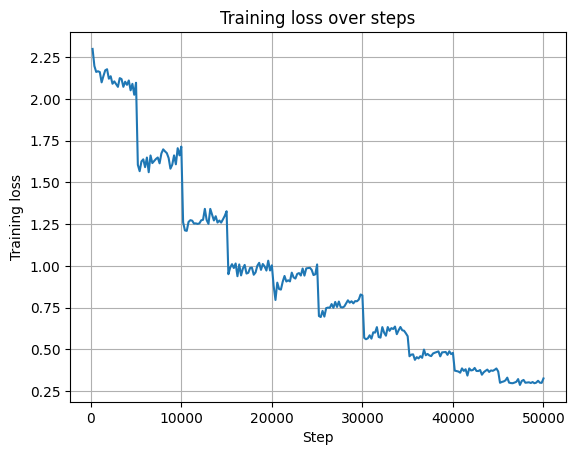

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Lọc entry có key "loss"
train_logs = [e for e in log_history if "loss" in e and "eval_loss" not in e]
df_train = pd.DataFrame(train_logs)

# df_train thường có các cột như: ["loss", "learning_rate", "epoch", "step"]

plt.plot(df_train["step"], df_train["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()


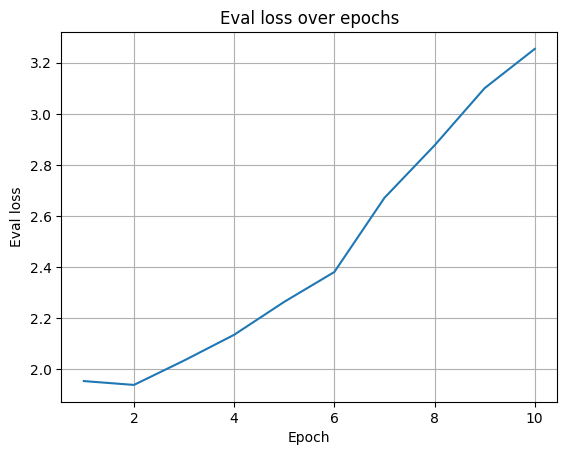

In [45]:
eval_logs = [e for e in log_history if "eval_loss" in e]
df_eval = pd.DataFrame(eval_logs)

plt.plot(df_eval["epoch"], df_eval["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Eval loss")
plt.title("Eval loss over epochs")
plt.grid(True)
plt.show()

## Save best model and push to hunggingface

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_token")

In [6]:
from huggingface_hub import login
login(token=secret_value_0)

In [46]:
best_model = trainer.state.best_model_checkpoint

In [47]:
# take best model
best_dir = "/kaggle/working/vit5-vietnews_small"

trainer.save_model(best_dir)        # lưu best model (weights + config)
tokenizer.save_pretrained(best_dir) # lưu tokenizer

print("Best model saved to:", best_dir)


Best model saved to: /kaggle/working/vit5-vietnews_small


In [ ]:
# Đặt tên repo trên Hugging Face (đổi myusername thành username HF của bạn)
repo_id = "lndat18/vit5-vietnews_small"

# Load lại best model từ thư mục
model_to_push = AutoModelForSeq2SeqLM.from_pretrained(best_dir)
tokenizer_to_push = AutoTokenizer.from_pretrained(best_dir)

# Đẩy lên Hugging Face Hub
model_to_push.push_to_hub(repo_id)
tokenizer_to_push.push_to_hub(repo_id)

print("Pushed to HF repo:", repo_id)


## Save dataset to hugging face

In [ ]:
!pip install -q "pyarrow>=21.0.0" "datasets>=2.19.0" "huggingface_hub>=0.24.0"

In [7]:
import pyarrow, datasets
print("pyarrow:", pyarrow.__version__)
print("datasets:", datasets.__version__)

pyarrow: 19.0.1
datasets: 4.4.1


In [ ]:
from datasets import Dataset, DatasetDict

data_dir = "/kaggle/working"

train_ds = Dataset.from_file(f"{data_dir}/train_clean.arrow")
val_ds   = Dataset.from_file(f"{data_dir}/val_clean.arrow")
test_ds  = Dataset.from_file(f"{data_dir}/test_clean.arrow")

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

repo_id = "lndat18/vit5-vietnews-small-clean"
dataset.push_to_hub(repo_id)


# 8. Evaluate

In [8]:
test_ds_clean = '/kaggle/working/test_clean.arrow'

In [ ]:
test_ds_clean.to_pandas().head()

In [53]:
# take self fine-tune model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("lndat18/vit5-vietnews_small")
model = AutoModelForSeq2SeqLM.from_pretrained("lndat18/vit5-vietnews_small")

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [61]:
test_sample = test_ds_clean[0]
test_article = test_sample['article']
test_abstract = test_sample['abstract']

print(test_article)
print('-'*50)
print(test_abstract)

Theo Hãng tin Bloomberg , trong bối cảnh nhiều doanh nghiệp nước ngoài đang tìm đường rút khỏi Trung Quốc nhằm ứng phó với sức ép từ thương chiến , chính quyền Ấn Độ đang cân nhắc đưa ra các chính sách khuyến khích tài chính nhằm thu hút các doanh nghiệp này mang dây chuyền sản xuất tới nước họ . Nguồn tin riêng của Bloomberg cho biết trong số các giải pháp đang được đưa ra cân nhắc , có những biện pháp đã và đang được áp dụng tại Việt Nam như chính sách ưu đãi về thuế cho doanh nghiệp và thời gian miễn thuế hay giảm thuế có thời hạn ( tax holiday ) . Theo tài liệu của Bộ thương mại Ấn Độ mà Bloomberg có được , các lĩnh vực công nghiệp sản xuất dự kiến được mời gọi đầu tư của Ấn Độ gồm đồ điện tử , thiết bị gia dụng , xe điện , giày dép và đồ chơi . Đây là một phần trong kế hoạch lớn hơn của Bộ thương mại Ấn Độ nhằm cắt giảm lệ thuộc vào nhập khẩu , đẩy mạnh xuất khẩu . Kế hoạch này còn cần có sự phê chuẩn của Bộ trưởng Tài chính Ấn Độ Nirmala Sitharaman . Ngoài những chính sách khuyến

In [64]:
def summarize_text(text, max_input_len=1024, max_new_tokens=512):
    inputs = tokenizer(
        text,
        max_length=max_input_len,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True,
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [65]:
pred = summarize_text(test_article)
print(pred)

Chính quyền Ấn Độ đang cân nhắc đưa ra các chính sách khuyến khích tài chính nhằm thu hút các doanh nghiệp nước ngoài mang dây chuyền sản xuất tới nước họ nhằm thu hẹp khoảng cách thâm hụt thương mại với Trung Quốc .


## Evaluate by ROUGE

In [9]:
from datasets import load_dataset
import torch

In [14]:
import evaluate

rouge = evaluate.load("rouge")


In [6]:
ds = load_dataset("lndat18/vit5-vietnews-small-clean")
test_ds_clean = ds['test']

In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("lndat18/vit5-vietnews_small")
model = AutoModelForSeq2SeqLM.from_pretrained("lndat18/vit5-vietnews_small")
model.to(device) 
model.eval()    

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [11]:
max_input_len = 1024   
max_new_tokens = 512    
batch_size = 8

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def generate_batch(batch):
    # batch["article"] là list các string
    inputs = tokenizer(
        batch["article"],
        max_length=max_input_len,
        truncation=True,
        padding="longest",
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True,
            # có thể thêm no_repeat_ngram_size=3 nếu muốn đỡ lặp
        )

    preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    # trả về 1 dict chứa list, datasets sẽ tự gắn thêm cột mới
    return {"pred_summary": preds}


In [12]:
test_pred = test_ds_clean.map(
    generate_batch,
    batched=True,
    batch_size=batch_size,
)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [17]:
preds = test_pred["pred_summary"]
refs  = test_pred["abstract"]

results = rouge.compute(
    predictions=preds,
    references=refs,
    use_stemmer=True,
)


In [22]:
print(test_pred)

Dataset({
    features: ['guid', 'title', 'abstract', 'article', 'pred_summary'],
    num_rows: 2000
})


In [18]:
for key, value in results.items():
    print(f"{key}: {value:.4f}")


rouge1: 0.5753
rouge2: 0.2669
rougeL: 0.3741
rougeLsum: 0.3741


## Evaluate by GPT-4.1 mini 

In [72]:
# Lấy đúng 5 mẫu ngẫu nhiên để gửi lên GPT
small_ds = test_pred.shuffle(seed=42).select(range(10))
eval_df = small_ds.to_pandas()

print(eval_df.columns)

Index(['guid', 'title', 'abstract', 'article', 'pred_summary'], dtype='object')


In [73]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_1 = user_secrets.get_secret("OpenAI_API_Key")


In [74]:
import json
import time
from openai import OpenAI, RateLimitError

client = OpenAI(api_key=secret_value_1)

SYSTEM_PROMPT = """
You are a strict and reliable evaluator for Vietnamese news summarization.
Your task is to evaluate the QUALITY of a candidate summary given:
(1) the original news article, and
(2) a reference summary written by a human.

You must rate the candidate summary on the following criteria from 1 to 5:
- relevance
- coherence
- fluency
- factuality
Also provide an overall score from 1 to 5.

Use this rubric:
- 1 = very poor, 3 = acceptable/medium, 5 = excellent.

Think step by step, then output ONLY a valid JSON object with the following fields:
{
  "relevance": int,
  "coherence": int,
  "fluency": int,
  "factuality": int,
  "overall": int,
  "short_explanation_vi": "one or two sentences in Vietnamese explaining the scores"
}
Do not output anything else.
"""

def call_judge_api(article, ref, cand):
    user_prompt = f"""
[INSTRUCTION]
Evaluate the following candidate summary.

[ORIGINAL_ARTICLE]
{article}

[REFERENCE_SUMMARY]
{ref}

[CANDIDATE_SUMMARY]
{cand}

Now provide your JSON evaluation.
"""
    resp = client.responses.create(
        model="gpt-4.1-mini",
        input=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
        max_output_tokens=256,
        temperature=0
    )
    text = resp.output[0].content[0].text
    return text

def judge_one_with_retry(article, ref, cand, max_retries=5, base_sleep=20):
    """
    Gọi GPT-4.1-mini với retry + exponential backoff khi bị RateLimitError 429.
    max_retries: số lần thử lại tối đa
    base_sleep: thời gian chờ ban đầu (giây), sẽ nhân đôi mỗi lần lỗi
    """
    for attempt in range(max_retries):
        try:
            raw = call_judge_api(article, ref, cand)
            # Parse JSON
            scores = json.loads(raw.strip())
            return scores
        except RateLimitError as e:
            # Lỗi 429 - vượt rate limit
            wait = base_sleep * (2 ** attempt)  # 20s, 40s, 80s, ...
            print(f"[RateLimit] Hit rate limit, sleeping {wait} seconds... (attempt {attempt+1})")
            time.sleep(wait)
        except json.JSONDecodeError:
            # Nếu output không parse được JSON, có thể log rồi bỏ qua
            print("[Warning] JSON decode error, raw output:")
            print(raw)
            return None
    print("[Error] Max retries exceeded, skipping this sample.")
    return None


In [75]:
results = []

for idx, row in eval_df.iterrows():
    print(f"=== Evaluating sample {idx} ===")
    article = row["article"]
    ref = row["abstract"]        
    cand = row["pred_summary"]

    scores = judge_one_with_retry(article, ref, cand)
    if scores is None:
        continue

    scores["idx"] = idx
    results.append(scores)

import pandas as pd
eval_scores = pd.DataFrame(results)
print(eval_scores.columns)


=== Evaluating sample 0 ===
[RateLimit] Hit rate limit, sleeping 20 seconds... (attempt 1)
[RateLimit] Hit rate limit, sleeping 40 seconds... (attempt 2)


KeyboardInterrupt: 

In [ ]:
print(eval_scores[['relevance', 'coherence', 'fluency', 'factuality', 'overall']])

In [ ]:
for article in eval_df['article']:
    print(article)
    print('-'*100)

In [ ]:
for article in eval_df['abstract']:
    print(article)
    print('-'*100)

In [ ]:
for article in eval_df['pred_summary']:
    print(article)
    print('-'*100)

In [ ]:
for llm_respone in eval_scores['pred_summary']:
    print(article)
    print('-'*100)

In [ ]:
for llm_respone in eval_scores['short_explanation_vi']:
    print(llm_respone)
    print('-'*100)